### Sentiment Analysis: Anne of Green Gables by L.M. Montgomery 
(updated analysis with Python 3.6 and NLTK 3.2.5)

In [1]:
!python -V

Python 3.6.0 :: Anaconda custom (64-bit)


#### Find a book, speech, short story, etc.
Download your text and save it locally.

In [3]:
# Read in the locally saved text file
with open('greengables.txt', 'r') as myfile:
    text=myfile.read().replace('\n', ' ')

print(type(text)) # check the data type
print(text[0:500]) # print the first n characters of the string

<class 'str'>
|MRS. Rachel Lynde lived just where the Avonlea main road dipped down into a little hollow, fringed with alders and ladies' eardrops and traversed by a brook that had its source away back in the woods of the old Cuthbert place; it was reputed to be an intricate, headlong brook in its earlier course through those woods, with dark secrets of pool and cascade; but by the time it reached Lynde's Hollow it was a quiet, well-conducted little stream, for not even a brook could run past Mrs. Rachel Lynd


#### Tokenization

The text is just one big, long string. To make more sense of the information, the string needs to be broken down into smaller pieces. This could be words or sentences. Since we want to look at the sentiment or emotion in one sentence at a time, we should break our string into sentences.

In [4]:
# Import the the NLTK package and the sentence tokenizer function
import nltk
from nltk import sent_tokenize
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.2.5.


In [5]:
# Tokenize into sentences
sentences = sent_tokenize(text)

In [6]:
# Print out some info about the sentences
print("Number of sentences in the novel:", len(sentences))
print("Data type: ", type(sentences), '\n')

# Print out a few sentences in the list
for i in (5,6,7):
    print(sentences[i], '\n')

Number of sentences in the novel: 6856
Data type:  <class 'list'> 

Since Avonlea occupied a little triangular peninsula jutting out into the Gulf of St. Lawrence with water on two sides of it, anybody who went out of it or into it had to pass over that hill road and so run the unseen gauntlet of Mrs. Rachel's all-seeing eye. 

She was sitting there one afternoon in early June. 

The sun was coming in at the window warm and bright; the orchard on the slope below the house was in a bridal flush of pinky-white bloom, hummed over by a myriad of bees. 



In [7]:
# Using the list of sentences:
# Find the sentence index for the sentence with "pudding sauce"
sauce = sentences.index("She was terribly mortified about the pudding sauce last week.")

for i in range(sauce,sauce+6):
    print(i,':\n', sentences[i])

2905 :
 She was terribly mortified about the pudding sauce last week.
2906 :
 We had a plum pudding for dinner on Tuesday and there was half the pudding and a pitcherful of sauce left over.
2907 :
 Marilla said there was enough for another dinner and told me to set it on the pantry shelf and cover it.
2908 :
 I meant to cover it just as much as could be, Diana, but when I carried it in I was imagining I was a nun--of course I'm a Protestant but I imagined I was a Catholic--taking the veil to bury a broken heart in cloistered seclusion; and I forgot all about covering the pudding sauce.
2909 :
 I thought of it next morning and ran to the pantry.
2910 :
 Diana, fancy if you can my extreme horror at finding a mouse drowned in that pudding sauce!


### Time for VADER

<img src="vader_luke_sentiment.jpg" alt="kitten" style="width: 600px;"/>

VADER *(**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.* 
(from the README)


[Info about the scoring](https://github.com/cjhutto/vaderSentiment#about-the-scoring)

In [8]:
# Import the VADER sentiment analysis tool
# (you will have already installed VADER on your system)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer() # easier to use with shorter name

In [9]:
# Example sentence
hate = 'Feel the hate flow through you.'

# Determine the sentiment score
score = analyzer.polarity_scores(hate)

print('Example sentence: ', hate)
print('Complete score: ', score)

Example sentence:  Feel the hate flow through you.
Complete score:  {'neg': 0.425, 'neu': 0.575, 'pos': 0.0, 'compound': -0.5719}


In [10]:
# Scores for example sentences from the novel

for i in (2905,2907,2910):
    print(sentences[i])
    vs = analyzer.polarity_scores(sentences[i])
    print("\n\t" + str(vs) + "\n\n")

She was terribly mortified about the pudding sauce last week.

	{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.5574}


Marilla said there was enough for another dinner and told me to set it on the pantry shelf and cover it.

	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Diana, fancy if you can my extreme horror at finding a mouse drowned in that pudding sauce!

	{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compound': -0.8356}




In [11]:
# Determine the complete score for each sentence sentence

# This is a list comprehension! List comprehensions are fun.
complete_score = [analyzer.polarity_scores(sentence) for sentence in sentences]


In [12]:
print('Data type returned: ', type(complete_score))
print('One element looks like this: ', complete_score[1])
print('Data type of element : ', type(complete_score[1]))

# Select just the last value ('compound' or polarity of the sentence)
polarity = [line.get('compound') for line in complete_score]

Data type returned:  <class 'list'>
One element looks like this:  {'neg': 0.02, 'neu': 0.96, 'pos': 0.02, 'compound': -0.2617}
Data type of element :  <class 'dict'>


### Lots of sentiment values...now what?

We now have a list of sentiment values, one for each sentence in the novel. While the data in this format might be useful for some purposes, it's probably better to average the sentiment over some number of sentences.

In [13]:
# Define a running mean function that averages over 
# a given window of width N (width = number of sentences)

import numpy as np

# function, give it x (list of sentiment values) and window N
def running_mean(x, N): 
    run_sum = np.cumsum(np.insert(x,0,0))
    return(run_sum[N:]-run_sum[:-N])/N

In [14]:
# Calculate a new list (vector) of polarity values, averaged over the 
# window; values of N between 50-80 sentences gave good results
polarity_sml = running_mean(polarity, 10)
polarity_med = running_mean(polarity, 60)
polarity_big = running_mean(polarity, 130)

# Create a vector of values for the x-axis as a percentage of the novel
xval     = [index*100/len(polarity) for index in range(len(polarity))]
xval_sml = [index*100/len(polarity_sml) for index in range(len(polarity_sml))]
xval_med = [index*100/len(polarity_med) for index in range(len(polarity_med))]
xval_big = [index*100/len(polarity_big) for index in range(len(polarity_big))]


### Plotting!

All the stuff in the rest of the notebook is for plotting. You're probably not doing anything wrong if your plotting code is long and looks complicated.

In [15]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd # just in case we need it later
import seaborn as sns # for styling

%matplotlib inline

# Settings for all figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 12

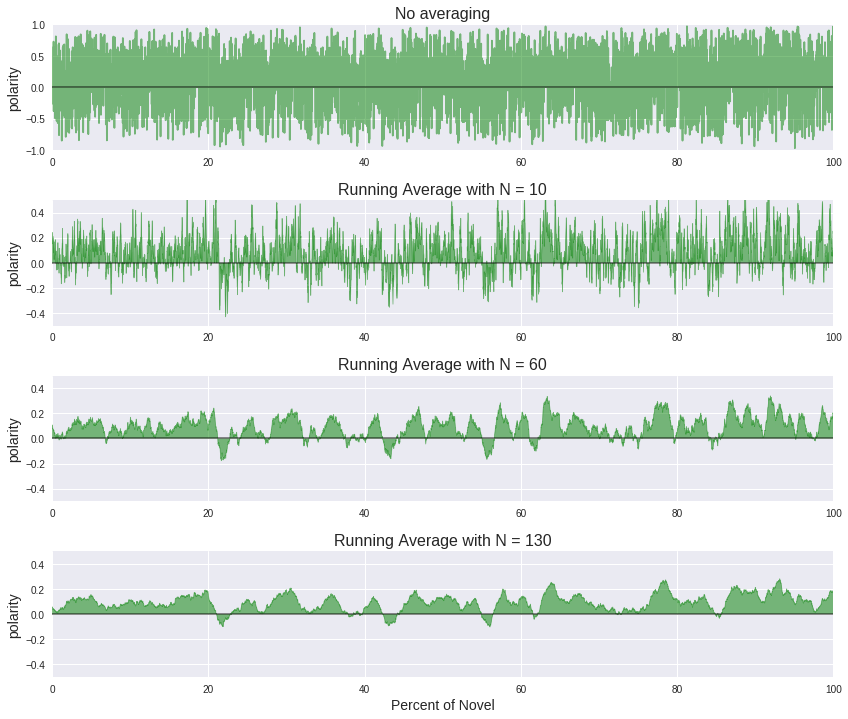

In [16]:
# Initialize a figure and set the size

fig = plt.figure(figsize=(14,12))

plt.subplot(411)
plt.subplots_adjust(wspace=0.5, hspace=0.4);
plt.plot(xval, polarity, 'g-', alpha=0.5)
plt.axis([0, 100, -1, 1])
plt.axhline(y=0, xmin=0, xmax=100, color='k', alpha=0.5)
plt.ylabel('polarity')
plt.title('No averaging')

plt.subplot(412)
plt.plot(xval_sml, polarity_sml, 'g-', alpha=0.5, linewidth=0.75)
plt.fill_between(xval_sml, 0, polarity_sml, facecolor='green', alpha=0.5)
plt.axis([0, 100, -0.5, 0.5])
plt.axhline(y=0, xmin=0, xmax=100, color='k', alpha=0.5)
plt.ylabel('polarity')
plt.title('Running Average with N = 10')

plt.subplot(413)
plt.plot(xval_med, polarity_med, 'g-', alpha=0.5, linewidth=0.75)
plt.fill_between(xval_med, 0, polarity_med, facecolor='green', alpha=0.5)
plt.axis([0, 100, -0.5, 0.5])
plt.axhline(y=0, xmin=0, xmax=100, color='k', alpha=0.5)
plt.ylabel('polarity')
plt.title('Running Average with N = 60')

plt.subplot(414)
plt.plot(xval_big, polarity_big, 'g-', alpha=0.5, linewidth=0.75)
plt.fill_between(xval_big, 0, polarity_big, facecolor='green', alpha=0.5)
plt.axis([0, 100, -0.5, 0.5])
plt.axhline(y=0, xmin=0, xmax=100, color='k', alpha=0.5)
plt.xlabel('Percent of Novel'), plt.ylabel('polarity')
plt.title('Running Average with N = 130')

plt.show()

In [17]:
# Make a string with the anne-otations to be added to the plot below
text = ['Anne is not a boy','Anne yells at Mrs. Lynde',
        'Anne meets Diana','Diana gets drunk','No more Diana!']
text.extend(['Haunted woods & Mr. Phillips departs',
             'Anne\'s broken ankle','Miss Stacey!','Charlottetown trip'])
text.extend(['Miss Stacey leaves','Anne wins the Avery'])

# Make more strings with the position of the text and arrows
xy_pos = [(7.3,-0.08),(22.5,-0.18),(28.44,0.25),(42.28,0.25),(43.5,-0.175)]
xytext_pos = [(6.8,-0.2),(22,-0.25),(24,0.4),(41,0.4),(42,-0.25)]

xy_pos.extend([(55.7,-0.18),(61.75,-0.12),(63.4,0.375),(77,0.3),(84.33,-0.13),(92.79,0.3)])
xytext_pos.extend([(56.5,-0.25),(62,-0.25),(64.75,0.4),(73,0.4),(81,-0.25),(91,0.4)])

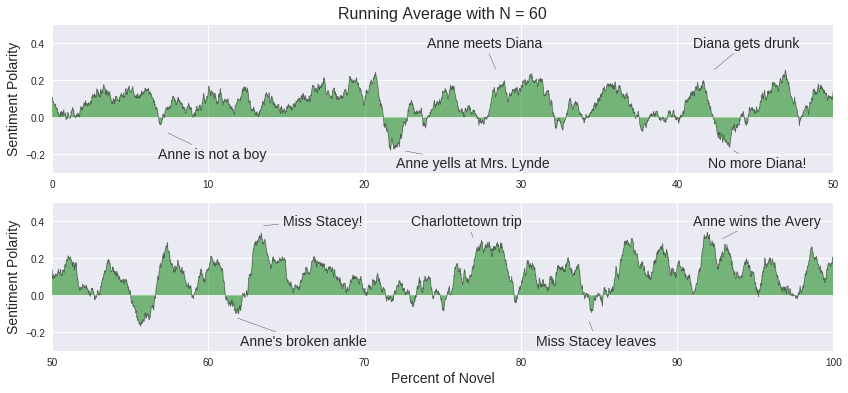

In [18]:
fig = plt.figure(figsize=(14,6))

plt.subplot(211)
plt.plot(xval_med, polarity_med, 'k-', linewidth=0.75, alpha=0.5)
plt.fill_between(xval_med, 0, polarity_med, facecolor='green', alpha=0.5)
plt.axis([0, 50, -0.3, 0.5])
#plt.axhline(y=0, xmin=0, xmax=50, color='k', alpha=0.5)
plt.ylabel('Sentiment Polarity')
plt.title('Running Average with N = 60')

for i in range(0,5):
    plt.annotate(text[i], xy=xy_pos[i], xytext=xytext_pos[i], 
                 arrowprops={'arrowstyle': '-'}, va='center')

plt.subplot(212)
plt.plot(xval_med, polarity_med, 'k-', linewidth=0.75, alpha=0.5)
plt.fill_between(xval_med, 0, polarity_med, facecolor='green', alpha=0.5)
plt.axhline(y=0, xmin=50, xmax=100, color='k', alpha=0.5)
plt.xlabel('Percent of Novel'),plt.ylabel('Sentiment Polarity')
plt.axis([50, 100, -0.3, 0.5])


for i in range(6,11):
    plt.annotate(text[i], xy=xy_pos[i], xytext=xytext_pos[i], 
                 arrowprops={'arrowstyle': '-'}, va='center')

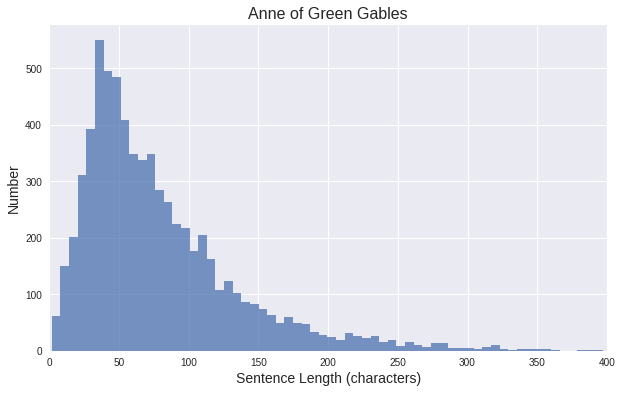

In [19]:
# Make a histogram of sentence lengths (in this case, the number of characters per sentence)
sen_length = [len(sentence) for sentence in sentences]

fig = plt.figure(figsize=(10,6))
plt.hist(sen_length, bins=150, alpha=0.75)
plt.xlim(0, 400)
plt.ylabel('Number'), plt.xlabel('Sentence Length (characters)')
plt.title('Anne of Green Gables')